# Structured Perceptron: Path-Level Experiments

This notebook switches from *cell-wise* prediction to *path-wise* prediction.
We run two experiments:

1. **Cost-aware path scoring**: use the **sum of cell costs along a path** to learn which path is optimal.
2. **Cost-free path scoring**: **do not use cost values** in features, and observe that the model can only rank paths coarsely (e.g., by length), not by exact cost.

The environment cost is row-dependent (`cost = 1 + row`), and the dataset is used only to sample start/goal pairs.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except Exception:
    plt.rcParams.update({"figure.dpi": 120})


## Load dataset (start/goal pairs)
We only use the dataset to get a list of `(start, goal)` pairs. The paths are computed separately.


In [5]:
DATA_PATH = Path("rain_grid_dataset.csv")
if not DATA_PATH.exists():
    DATA_PATH = Path("rain_grid_dataset.csv")

df = pd.read_csv(DATA_PATH)
df = df.sort_values(["episode", "step"])

grid_size = int(max(
    df["state_row"].max(),
    df["state_col"].max(),
    df["next_row"].max(),
    df["next_col"].max(),
) + 1)

pairs = []
for episode, g in df.groupby("episode"):
    start = (int(g.iloc[0]["state_row"]), int(g.iloc[0]["state_col"]))
    goal = (int(g.iloc[-1]["next_row"]), int(g.iloc[-1]["next_col"]))
    pairs.append((start, goal))

grid_size, len(pairs)


(5, 200)

## Path helpers
We enumerate all **shortest** paths between a start and goal (monotonic moves only).


In [16]:
def build_cost_grid(size: int) -> np.ndarray:
    rows = np.arange(size, dtype=np.float32)
    row_costs = 1.0 + rows
    return np.repeat(row_costs[:, None], size, axis=1)


cost_grid = build_cost_grid(grid_size)


def enumerate_shortest_paths(start, goal):
    sr, sc = start
    gr, gc = goal
    dr = gr - sr
    dc = gc - sc
    step_r = 1 if dr > 0 else -1 if dr < 0 else 0
    step_c = 1 if dc > 0 else -1 if dc < 0 else 0
    r_steps = abs(dr)
    c_steps = abs(dc)

    paths = []

    def dfs(r, c, r_left, c_left, path):
        if r_left == 0 and c_left == 0:
            paths.append(path)
            return
        if r_left > 0:
            dfs(r + step_r, c, r_left - 1, c_left, path + [(r + step_r, c)])
        if c_left > 0:
            dfs(r, c + step_c, r_left, c_left - 1, path + [(r, c + step_c)])

    dfs(sr, sc, r_steps, c_steps, [(sr, sc)])
    return paths


def path_cost(path, grid):
    if len(path) <= 1:
        return 0.0
    # print(path[1:])    
    return float(sum(grid[r, c] for r, c in path[1:]))


## Build training examples
Each example contains a start/goal pair, all shortest paths, and the true optimal path (minimum cost).


In [18]:
examples = []
for start, goal in pairs:
    paths = enumerate_shortest_paths(start, goal)
    # print(paths)
    # print(paths[0])
    costs = [path_cost(p, cost_grid) for p in paths]
    best_idx = int(np.argmin(costs))
    examples.append({
        "start": start,
        "goal": goal,
        "paths": paths,
        "costs": costs,
        "best_path": paths[best_idx],
        "best_cost": costs[best_idx],
    })

rng = np.random.default_rng(0)
indices = rng.permutation(len(examples))
split = int(0.8 * len(indices))
train_examples = [examples[i] for i in indices[:split]]
test_examples = [examples[i] for i in indices[split:]]

len(train_examples), len(test_examples)


(160, 40)

## Structured perceptron utilities
We predict a path by scoring all candidates and selecting the highest score.


In [19]:
def predict_path(example, w, phi):
    scores = [float(np.dot(w, phi(p))) for p in example["paths"]]
    best_idx = int(np.argmax(scores))
    return example["paths"][best_idx]


def train_perceptron(examples, phi, epochs=15, seed=0):
    dim = len(phi(examples[0]["paths"][0]))
    w = np.zeros(dim, dtype=np.float32)
    rng = np.random.default_rng(seed)
    history = []
    for epoch in range(epochs):
        rng.shuffle(examples)
        errors = 0
        for ex in examples:
            pred = predict_path(ex, w, phi)
            if pred != ex["best_path"]:
                w += phi(ex["best_path"]) - phi(pred)
                errors += 1
        history.append(1 - errors / len(examples))
    return w, history


def evaluate(examples, w, phi, grid):
    pred_costs = []
    optimal_costs = []
    optimal_hits = 0
    for ex in examples:
        pred = predict_path(ex, w, phi)
        pred_cost = path_cost(pred, grid)
        optimal_cost = min(ex["costs"])
        pred_costs.append(pred_cost)
        optimal_costs.append(optimal_cost)
        if abs(pred_cost - optimal_cost) < 1e-6:
            optimal_hits += 1

    pred_costs = np.array(pred_costs)
    optimal_costs = np.array(optimal_costs)
    return {
        "avg_cost_gap": float(np.mean(pred_costs - optimal_costs)),
        "avg_cost_ratio": float(np.mean(pred_costs / optimal_costs)),
        "optimal_rate": float(optimal_hits / len(examples)),
    }


# Experiment 1: Cost-aware path scoring
We use **only the sum of cell costs** along a path (not per-cell labels) plus length.


In [20]:
def phi_cost(path):
    total = path_cost(path, cost_grid)
    length = len(path) - 1
    # Negative values so that higher score = lower cost.
    return np.array([1.0, -total, -length], dtype=np.float32)

w_cost, hist_cost = train_perceptron(train_examples, phi_cost, epochs=15, seed=0)
hist_cost


[0.99375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

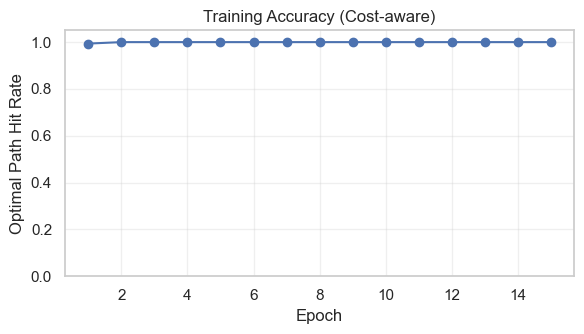

In [21]:
plt.figure(figsize=(6, 3.5))
plt.plot(np.arange(1, len(hist_cost) + 1), hist_cost, marker="o")
plt.ylim(0.0, 1.05)
plt.title("Training Accuracy (Cost-aware)")
plt.xlabel("Epoch")
plt.ylabel("Optimal Path Hit Rate")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [22]:
train_eval_cost = evaluate(train_examples, w_cost, phi_cost, cost_grid)
test_eval_cost = evaluate(test_examples, w_cost, phi_cost, cost_grid)
train_eval_cost, test_eval_cost


({'avg_cost_gap': 0.0, 'avg_cost_ratio': 1.0, 'optimal_rate': 1.0},
 {'avg_cost_gap': 0.0, 'avg_cost_ratio': 1.0, 'optimal_rate': 1.0})

# Experiment 2: Cost-free path scoring
We remove any dependence on cell cost values. Only **path length** is used,
so the model can rank shorter paths as better, but cannot distinguish among
equal-length paths.


In [23]:
def phi_no_cost(path):
    length = len(path) - 1
    return np.array([1.0, -length], dtype=np.float32)

w_no_cost, hist_no_cost = train_perceptron(train_examples, phi_no_cost, epochs=15, seed=0)
hist_no_cost


[0.25625,
 0.25625,
 0.25625,
 0.25625,
 0.25625,
 0.25625,
 0.25625,
 0.25625,
 0.25625,
 0.25625,
 0.25625,
 0.25625,
 0.25625,
 0.25625,
 0.25625]

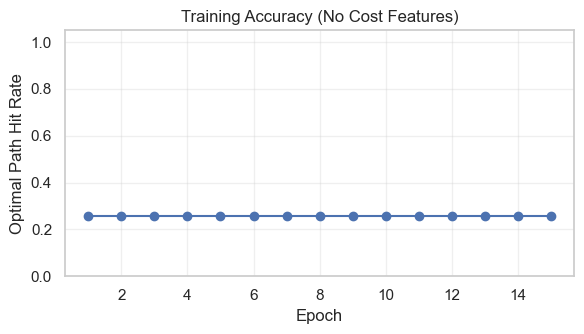

In [24]:
plt.figure(figsize=(6, 3.5))
plt.plot(np.arange(1, len(hist_no_cost) + 1), hist_no_cost, marker="o")
plt.ylim(0.0, 1.05)
plt.title("Training Accuracy (No Cost Features)")
plt.xlabel("Epoch")
plt.ylabel("Optimal Path Hit Rate")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [25]:
train_eval_no_cost = evaluate(train_examples, w_no_cost, phi_no_cost, cost_grid)
test_eval_no_cost = evaluate(test_examples, w_no_cost, phi_no_cost, cost_grid)
train_eval_no_cost, test_eval_no_cost


({'avg_cost_gap': 7.075,
  'avg_cost_ratio': 1.4199142156862743,
  'optimal_rate': 0.25625},
 {'avg_cost_gap': 7.0,
  'avg_cost_ratio': 1.4162908496732025,
  'optimal_rate': 0.25})

## Visual comparison on a sample


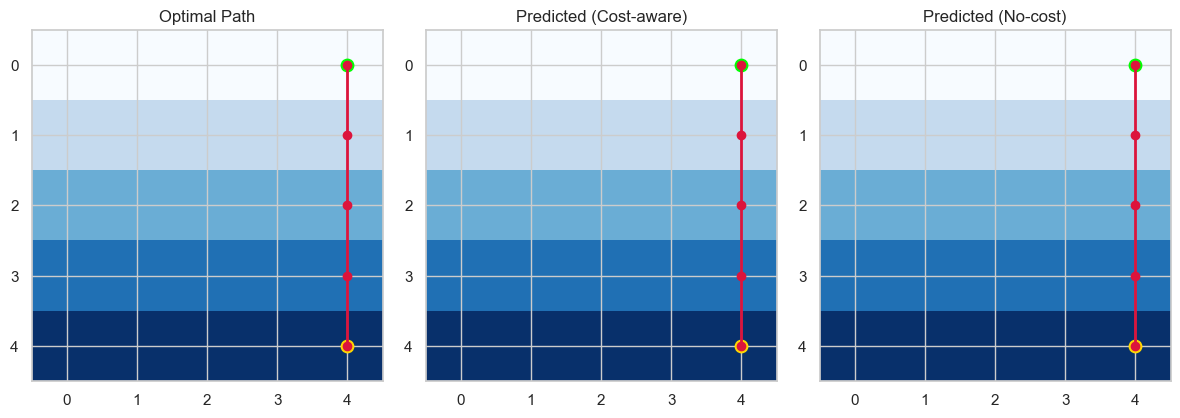

In [26]:
def plot_path(grid, path, ax, title):
    ax.imshow(grid, cmap="Blues")
    xs = [c for r, c in path]
    ys = [r for r, c in path]
    ax.plot(xs, ys, marker="o", color="crimson", linewidth=2)
    ax.scatter([xs[0]], [ys[0]], color="lime", s=80, label="start")
    ax.scatter([xs[-1]], [ys[-1]], color="gold", s=80, label="goal")
    ax.set_title(title)
    ax.set_xticks(range(grid.shape[1]))
    ax.set_yticks(range(grid.shape[0]))

sample = test_examples[0]
pred_cost = predict_path(sample, w_cost, phi_cost)
pred_no_cost = predict_path(sample, w_no_cost, phi_no_cost)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_path(cost_grid, sample["best_path"], axes[0], "Optimal Path")
plot_path(cost_grid, pred_cost, axes[1], "Predicted (Cost-aware)")
plot_path(cost_grid, pred_no_cost, axes[2], "Predicted (No-cost)")
plt.tight_layout()
plt.show()


## Notes
- Cost-aware features can distinguish between different *shortest* paths (order of moves).
- Without cost features, the model typically prefers short paths but cannot pick the cheapest
  among equal-length candidates.
